# Title - Fitbit Time Series Project

# Goal
1.


Notes for intial data peeking:
1. Missing data 6/27/2018 - 7/6/2018
2. Most of the records are missing Food/ Food log information.  
> Available: May - June 1 record, October - November 7 records
3. Overall data range 4/26/2018 - 12/6/2018

Index - 
April, May, June, Aug, Sept, Oct, Nov: 36-67
July: 36-66
Dec: 36-45

Hypothesis
1. Missing value can be predicted with by similar days of the weeks (weekday/ weekend
2. Missing value can be affected by month/ season of the year
3. Explore: hypothesis testing, df.corr on 
'cal_burn', 'steps', 'distance', 'floors', 'min_sed'
'min_sed','min_active_light', 'min_active_fairly', 'min_active_very','cal_activity'
'cal_burn', 'cal_activity'


# Deliverables

1. Notebook: 
> material & methods, include data preparation, summary/ data dictionary
>
> 
>
> analyses
>
> conclusions
>
> predictions: 
>
> missing two weeks worth of data (csv file)
> 
> include comment about the individual who was wearing this fitness tracker

2. Prediction result: missing two weeks worth of data (csv file)

3. 2 slides, audience = a general audience. 
> Include at least one visualization, clearly labeled

In [6]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
#import prepare
#import summarize
#from acquire import get_store_data
#from prepare import prep_store_data, split_store_data
# from summarize import df_summary

# Acquisition

In [7]:
df = acquire.acquire()

In [8]:
df = acquire.handle_obj_type(df)

In [9]:
df = acquire.basic_clean(df)

Total length of df is: 225
Total length of none-repeating dates is: 225


In [10]:
train, test = acquire.split_date(df)

            cal_burn  steps  distance  floors  min_sed  min_active_light  \
date                                                                       
2018-04-26      2635   2931      1.38       2     1347                93   
2018-04-27      3649   9971      4.70      19     1158               219   
2018-04-28      3379   3521      1.66       2      702               155   
2018-04-29      2851   1639      0.77       0      891               122   
2018-04-30      2825   1323      0.62       0      880               104   

            min_active_fairly  min_active_very  cal_activity  
date                                                          
2018-04-26                  0                0           566  
2018-04-27                 46               17          1752  
2018-04-28                 22               11          1124  
2018-04-29                  0                0           602  
2018-04-30                  0                0           540  
            cal_burn  step

# Explore and Prepare

In [ ]:
# explore

In [ ]:
def prep_data(df: pd.DataFrame) -> pd.DataFrame:
    return (df.assign(ds=pd.to_datetime(df.Month_Invoiced)).sort_values('ds')
            .assign(y=df.Amount)\
            .groupby(['ds'])['y'].sum().reset_index().set_index('ds'))

In [ ]:
df = prep_data(df)

In [ ]:
def split_store_data(df, train_prop): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size].reset_index(), df[train_size:len(df)].reset_index()
    return train, test

In [ ]:
train, test = split_store_data(df2, train_prop=.80)

print('Observations: %d' % (len(df2)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

In [ ]:
train = train.set_index('ds')
test = test.set_index('ds')

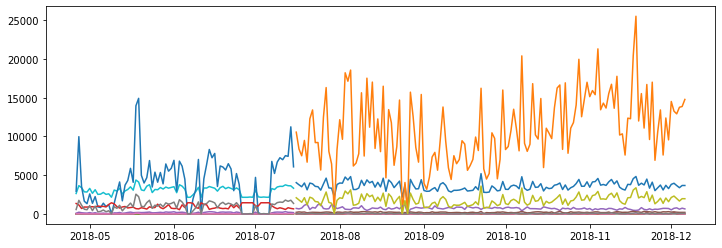

In [12]:
# peek data
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)

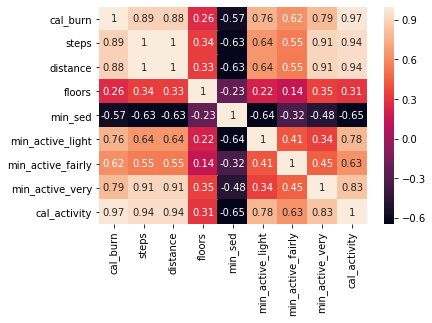

In [14]:
sns.heatmap(df.corr(), annot = True)

# Model

In [ ]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [ ]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

In [ ]:
# create df to store MSE & RMSE
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [ ]:
periods = 30
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

# plot_and_eval(target_vars, train, test)
# eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 12, 26, 52, 104]
for p in period_vals:
    yhat['y'] = train.y.rolling(p).mean().iloc[-1]
    plt.plot(yhat.y)
    print('\nrolling averge period:',p)
    print('\nitem sales\n')
    evaluate('y', train = train, test = test)